In [1]:
import os

In [2]:
# Here we will evaluate the model on the test set
# Import the directory_benchmark module from the eval directory

import sys
sys.path.append("../../")
from eval.directory_benchmark import benchmark_directories, benchmark_single_file

def benchmark(test_set_labels_dir: str, pred_labels_dir: str, iou_threshold: float = 0.0):
    """
    Benchmark the model on the test set using the new directory_benchmark script
    
    Args:
        test_set_labels_dir: Directory containing ground truth JSON files
        pred_labels_dir: Directory containing prediction JSON files  
        iou_threshold: IoU threshold for bounding box matching (default: 0.5)
    
    Returns:
        pandas.DataFrame: Results dataframe with simplified columns
    """
    return benchmark_directories(test_set_labels_dir, pred_labels_dir, iou_threshold)

def benchmark_from_file(test_data_file: str, pred_labels_dir: str, iou_threshold: float = 0.5, return_metrics: bool = False):
    """
    Benchmark the model on the test set using a single JSON file containing all test data
    
    Args:
        test_data_file: Path to JSON file containing all ground truth data in format:
                       [{"file_name": "...", "labels": [...]}, ...]
        pred_labels_dir: Directory containing prediction JSON files  
        iou_threshold: IoU threshold for bounding box matching (default: 0.0)
        return_metrics: If True, also return native metrics from the evaluator
    
    Returns:
        pandas.DataFrame: Results dataframe with simplified columns
        If return_metrics=True, returns (results_df, metrics_dict)
    """
    return benchmark_single_file(test_data_file, pred_labels_dir, iou_threshold, return_metrics=return_metrics)

In [3]:
from typing import List, Dict, Any, Tuple
import pandas as pd
from matplotlib import colors as mcolors


def _blue_variants(n: int, base_hex: str = "#2980b9"):
    base = mcolors.to_rgb(base_hex)
    variants = []
    denom = max(1, n - 1)
    for i in range(max(1, n)):
        # t in [0.15, 0.85]: blend base towards white for lighter distinct shades
        t = 0.15 + 0.7 * (i / denom)
        c = tuple((1 - t) * base[j] + t * 1.0 for j in range(3))
        variants.append(c)
    return variants


def _shorten_pred_dir_path(path_str: str) -> str:
    s = str(path_str).replace("\\", "/")
    key = "/model_pred/"
    if key in s:
        return s.split(key, 1)[1].lstrip("/")
    parts = s.strip("/").split("/")
    # Fallback: last 3 parts
    return "/".join(parts[-3:]) if len(parts) >= 3 else s


def benchmark_from_file_multiple_native_metrics(
    test_data_file: str,
    pred_labels_dirs: List[str],
    iou_threshold: float = 0.5,
    return_results: bool = True,
) -> Tuple[Dict[str, Dict[str, Any]], pd.DataFrame, pd.DataFrame]:
    """
    Run benchmark_single_file across multiple prediction directories and aggregate the
    internal metrics it computes (no recomputation from the results DataFrame).

    Returns:
        by_dir: mapping of pred_dir -> { 'results': DataFrame (optional),
                                         'metrics_by_type': DataFrame,
                                         'overall': dict }
        metrics_long: DataFrame with per-entity metrics for each pred_dir (for plotting)
        overall_df: DataFrame with overall metrics per pred_dir
    """
    by_dir: Dict[str, Dict[str, Any]] = {}
    long_rows = []
    overall_rows = []

    for pred_dir in pred_labels_dirs:
        # Use the updated function that returns internal metrics
        res = benchmark_from_file(test_data_file, pred_dir, iou_threshold, return_metrics=True)
        if isinstance(res, tuple) and len(res) == 2:
            results_df, metrics = res
        else:
            results_df, metrics = res, {'by_type': [], 'overall': {}}

        metrics_by_type_df = pd.DataFrame(metrics.get('by_type', []))
        overall_metrics = metrics.get('overall', {})
        label = _shorten_pred_dir_path(pred_dir)

        rec: Dict[str, Any] = {
            'metrics_by_type': metrics_by_type_df,
            'overall': overall_metrics,
        }
        if return_results:
            rec['results'] = results_df

        by_dir[pred_dir] = rec

        if not metrics_by_type_df.empty:
            df_with_dir = metrics_by_type_df.copy()
            df_with_dir.insert(0, 'pred_dir', label)
            long_rows.append(df_with_dir)

        overall_row = {'pred_dir': label, **overall_metrics}
        overall_rows.append(overall_row)

    metrics_long = pd.concat(long_rows, ignore_index=True) if long_rows else pd.DataFrame(
        columns=['pred_dir','entity_type','precision','recall','f1','tp','fp','fn','gt']
    )
    overall_df = pd.DataFrame(overall_rows)

    return by_dir, metrics_long, overall_df


In [4]:
import re
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors


def _parse_overall_pred_dir_label(label: str) -> dict:
    """
    Parse shortened pred_dir label into components: subset, rank, checkpoint, epoch.
    Expected formats (shortened):
      any_annotator/r64_alpha128_.../checkpoint-94
      majority_annotator_2/r16_alpha128_.../checkpoint-188
    """
    s = str(label)
    parts = s.split('/')
    subset = parts[0] if parts else s
    # rank like r8, r16, r64 in the next segment
    rank = None
    if len(parts) >= 2:
        m = re.search(r"r(\d+)", parts[1])
        if m:
            rank = int(m.group(1))
    # checkpoint
    step = None
    m = re.search(r"checkpoint-(\d+)", s)
    if m:
        step = int(m.group(1))
    # Map checkpoint to epoch; defaults use step/47 if provided
    epoch = None
    if step is not None:
        # Known mapping examples
        known = {94: 2, 188: 4, 282: 6}
        epoch = known.get(step, round(step / 47))
    subset_pretty = 'majority_voting (2)' if subset == 'majority_annotator_2' else subset
    return {
        'subset': subset,
        'subset_pretty': subset_pretty,
        'rank': rank,
        'checkpoint': step,
        'epoch': epoch,
    }


def prepare_overall_with_parsed(overall_df):
    df = overall_df.copy()
    parsed = df['pred_dir'].apply(_parse_overall_pred_dir_label)
    df = pd.concat([df, parsed.apply(pd.Series)], axis=1)
    # Keep only rows with parsed epoch and rank
    df = df[df['epoch'].notna() & df['rank'].notna()]
    df['epoch'] = df['epoch'].astype(int)
    df['rank'] = df['rank'].astype(int)
    return df


def plot_overall_metrics_by_epoch(
    overall_df: pd.DataFrame,
    metrics: tuple = ('f1',),
    figsize: tuple = (4, 4),
    title_template: str | None = None,
    y_label_template: str | None = None,
):
    """
    Academic-styled plot of metrics over epochs per subset, with separate lines for each rank.
    Draws a baseline F1=0.04 for F1 plots and ensures it is visible.
    """
    df = prepare_overall_with_parsed(overall_df)
    if df.empty:
        return

    rc = {
        'font.family': 'serif',
        'font.size': 10,
        'axes.titlesize': 10,
        'axes.labelsize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        'axes.linewidth': 0.8,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.size': 3,
        'ytick.major.size': 3,
    }

    marker_cycle = ['o', 'o', 'o', 'o', 'o', 'P', 'X']
    linestyle_cycle = ['-', '--', '-.', ':']

    def blend(c_from, c_to, t: float):
        return tuple((1 - t) * c_from[i] + t * c_to[i] for i in range(3))

    base_rgb = mcolors.to_rgb("#2980b9")
    black = (0.0, 0.0, 0.0)
    white = (1.0, 1.0, 1.0)

    with plt.rc_context(rc):
        for subset, group in df.groupby('subset_pretty'):
            epochs_sorted = sorted(group['epoch'].unique())
            unique_ranks = sorted(group['rank'].unique())
            for metric in metrics:
                fig, ax = plt.subplots(figsize=figsize)

                # Clean axes spines
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)

                # Order ranks by highest F1 (desc) for color assignment
                if metric == 'f1':
                    rank_scores = group.groupby('rank')[metric].max().sort_values(ascending=False)
                    ordered_ranks = list(rank_scores.index)
                else:
                    ordered_ranks = unique_ranks

                # Build color map per requirement
                color_map = {}
                for i, rank in enumerate(ordered_ranks):
                    if i == 0:
                        # Highest F1: darken base slightly toward black
                        color_map[rank] = blend(base_rgb, black, 0.25)
                    elif i == 1:
                        # Second best: base color
                        color_map[rank] = base_rgb
                    else:
                        # Others: bend slightly toward white; keep visible (limit to 0.35)
                        t = min(0.35, 0.15 + 0.08 * (i - 2))
                        color_map[rank] = blend(base_rgb, white, t)

                # Plot lines per rank
                for rank in unique_ranks:
                    g = group[group['rank'] == rank]
                    g_sorted = g.sort_values('epoch')
                    color = color_map.get(rank, base_rgb)
                    idx = ordered_ranks.index(rank) if rank in ordered_ranks else 0
                    marker = marker_cycle[idx % len(marker_cycle)]
                    lstyle = '-'
                    lw = 2.0 if (metric == 'f1' and rank == ordered_ranks[0]) else (1.8 if (metric == 'f1' and rank == ordered_ranks[1] if len(ordered_ranks) > 1 else False) else 1.6)
                    ax.plot(
                        g_sorted['epoch'],
                        g_sorted[metric],
                        marker=marker,
                        linestyle=lstyle,
                        color=color,
                        markersize=5,
                        linewidth=lw,
                        label=f"r={rank}",
                    )

                # Baseline and y-limits
                if metric == 'f1':
                    baseline = 0.04
                    ax.axhline(baseline, color='red', linestyle='--', linewidth=1.8, zorder=10, label='Baseline F1=0.04')
                    y_max = float(max(group[metric].max(), baseline)) if not group.empty else baseline
                else:
                    y_max = float(group[metric].max()) if not group.empty else 1.0
                ax.set_ylim(0.0, min(1.0, y_max * 1.10 if y_max < 1.0 else y_max * 1.05))
                ax.margins(y=0.05)

                if title_template:
                    ax.set_title(title_template.format(subset=subset, metric=metric.upper()))
                else:
                    ax.set_title(f"{subset} — {metric.UPPER()} vs Epoch")
                ax.set_xlabel('Epoch')
                if y_label_template:
                    ax.set_ylabel(y_label_template.format(metric=metric.upper(), subset=subset))
                else:
                    ax.set_ylabel(metric.upper())
                ax.set_xticks(epochs_sorted)
                # Vertical guide lines at each epoch
                for x in epochs_sorted:
                    ax.axvline(x, color='0.85', linewidth=0.8, alpha=0.6, zorder=0)
                ax.grid(axis='y', linestyle=':', linewidth=0.6, alpha=0.6)
                ax.legend()
                plt.tight_layout()
                plt.savefig(f"f1_epoch_plot_{subset}.png", dpi=300)
                plt.show()


In [13]:
# Example usage for native metrics aggregation
test_data_file = "/Volumes/MyDataDrive/thesis/code-2/new-data/IIT-CDIP/test/test-data-iit-cdip-840px.json"
pred_dirs = [
    # r8
    "/Volumes/MyDataDrive/thesis/code-2/new-data/trained_model_pred_without_bbox/model_pred/any_annotator/r8_alpha16_train-data-mixed-840px-annotator-1-without-bbox_lr0_000042/checkpoint-94",
    "/Volumes/MyDataDrive/thesis/code-2/new-data/trained_model_pred_without_bbox/model_pred/any_annotator/r8_alpha16_train-data-mixed-840px-annotator-1-without-bbox_lr0_000042/checkpoint-188",
    "/Volumes/MyDataDrive/thesis/code-2/new-data/trained_model_pred_without_bbox/model_pred/any_annotator/r8_alpha16_train-data-mixed-840px-annotator-1-without-bbox_lr0_000042/checkpoint-282",

    # r16
    "/Volumes/MyDataDrive/thesis/code-2/new-data/trained_model_pred_without_bbox/model_pred/any_annotator/r16_alpha32_train-data-mixed-840px-annotator-1-without-bbox_lr0_000042/checkpoint-94",
    "/Volumes/MyDataDrive/thesis/code-2/new-data/trained_model_pred_without_bbox/model_pred/any_annotator/r16_alpha32_train-data-mixed-840px-annotator-1-without-bbox_lr0_000042/checkpoint-188",
    "/Volumes/MyDataDrive/thesis/code-2/new-data/trained_model_pred_without_bbox/model_pred/any_annotator/r16_alpha32_train-data-mixed-840px-annotator-1-without-bbox_lr0_000042/checkpoint-282",

    # r= 64
    "/Volumes/MyDataDrive/thesis/code-2/new-data/trained_model_pred_without_bbox/model_pred/any_annotator/r64_alpha128_train-data-mixed-840px-annotator-1-without-bbox_lr0_000042/checkpoint-94",
    "/Volumes/MyDataDrive/thesis/code-2/new-data/trained_model_pred_without_bbox/model_pred/any_annotator/r64_alpha128_train-data-mixed-840px-annotator-1-without-bbox_lr0_000042/checkpoint-188",
    "/Volumes/MyDataDrive/thesis/code-2/new-data/trained_model_pred_without_bbox/model_pred/any_annotator/r64_alpha128_train-data-mixed-840px-annotator-1-without-bbox_lr0_000042/checkpoint-282"
]
by_dir, metrics_long, overall_df = benchmark_from_file_multiple_native_metrics(
    test_data_file,
    pred_dirs,
    iou_threshold=0.0,
    return_results=True,
)
# display(metrics_long.head())
# display(overall_df)
item = pred_dirs[1]
print(overall_df.loc[overall_df['pred_dir'] == item])

Loading test data from: /Volumes/MyDataDrive/thesis/code-2/new-data/IIT-CDIP/test/test-data-iit-cdip-840px.json
Found 100 ground truth files to process
Files with predictions: 100
Files without predictions: 0 (will be treated as complete prediction failures)

Counting all ground truth entities...
  fhfb0066_page1: 3 entities
  fjcc0074_page4: 17 entities
  fgbf0249_page5: 31 entities
  fhbh0030_page1: 10 entities
  fgcg0076_page1: 5 entities
  fgdp0140_page1: 11 entities
  fgvl0222_page1: 25 entities
  fhvc0235_page2: 57 entities
  fhnm0001_page1: 86 entities
  fjgh0000_page1: 10 entities
  fhyg0141_page1: 15 entities
  fhyn0144_page1: 12 entities
  fgvd0138_page1: 16 entities
  fgvk0122_page3: 7 entities
  fgvg0019_page1: 6 entities
  fhhd0023_page2: 8 entities
  fhkm0113_page1: 6 entities
  fhxj0190_page1: 12 entities
  fhvb0035_page1: 16 entities
  fjbw0138_page1: 7 entities
  fgfy0251_page1: 17 entities
  fgmp0189_page3: 21 entities
  fjjc0186_page2: 9 entities
  fgxw0053_page1: 8 

In [14]:
print(overall_df)

                                            pred_dir  precision  recall  \
0  any_annotator/r8_alpha16_train-data-mixed-840p...     0.5865  0.3545   
1  any_annotator/r8_alpha16_train-data-mixed-840p...     0.5704  0.3078   
2  any_annotator/r8_alpha16_train-data-mixed-840p...     0.5324  0.3416   
3  any_annotator/r16_alpha32_train-data-mixed-840...     0.5647  0.3201   
4  any_annotator/r16_alpha32_train-data-mixed-840...     0.4068  0.3045   
5  any_annotator/r16_alpha32_train-data-mixed-840...     0.6016  0.3519   
6  any_annotator/r64_alpha128_train-data-mixed-84...     0.5998  0.3474   
7  any_annotator/r64_alpha128_train-data-mixed-84...     0.6029  0.3214   
8  any_annotator/r64_alpha128_train-data-mixed-84...     0.6487  0.3045   

       f1   tp   fp    fn    gt  
0  0.4419  546  385   994  1540  
1  0.3998  474  357  1066  1540  
2  0.4161  526  462  1014  1540  
3  0.4086  493  380  1047  1540  
4  0.3483  469  684  1071  1540  
5  0.4441  542  359   998  1540  
6  0.4400  

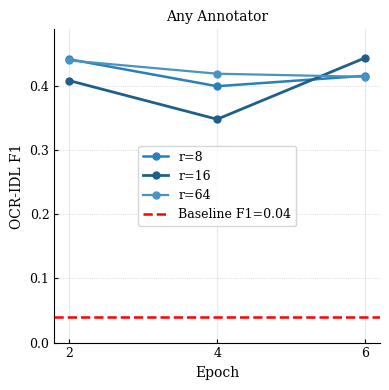

In [15]:
plot_overall_metrics_by_epoch(overall_df, metrics=('f1',), title_template ="Any Annotator", y_label_template="OCR-IDL F1")

In [11]:
pred_dirs = [
    # r8
   "/Volumes/MyDataDrive/thesis/code-2/new-data/trained_model_pred_without_bbox/model_pred/majority_annotator_2/r8_alpha16_train-data-mixed-840px-annotator-2-without-bbox_lr0_000042/checkpoint-94",
   "/Volumes/MyDataDrive/thesis/code-2/new-data/trained_model_pred_without_bbox/model_pred/majority_annotator_2/r8_alpha16_train-data-mixed-840px-annotator-2-without-bbox_lr0_000042/checkpoint-188",
   "/Volumes/MyDataDrive/thesis/code-2/new-data/trained_model_pred_without_bbox/model_pred/majority_annotator_2/r8_alpha16_train-data-mixed-840px-annotator-2-without-bbox_lr0_000042/checkpoint-282",

   # r=16
   "/Volumes/MyDataDrive/thesis/code-2/new-data/trained_model_pred_without_bbox/model_pred/majority_annotator_2/r16_alpha32_train-data-mixed-840px-annotator-2-without-bbox_lr0_000042/checkpoint-94",
   "/Volumes/MyDataDrive/thesis/code-2/new-data/trained_model_pred_without_bbox/model_pred/majority_annotator_2/r16_alpha32_train-data-mixed-840px-annotator-2-without-bbox_lr0_000042/checkpoint-188",
   "/Volumes/MyDataDrive/thesis/code-2/new-data/trained_model_pred_without_bbox/model_pred/majority_annotator_2/r16_alpha32_train-data-mixed-840px-annotator-2-without-bbox_lr0_000042/checkpoint-282",

   # r=64
   "/Volumes/MyDataDrive/thesis/code-2/new-data/trained_model_pred_without_bbox/model_pred/majority_annotator_2/r64_alpha128_train-data-mixed-840px-annotator-2-without-bbox_lr0_000042/checkpoint-94",
   "/Volumes/MyDataDrive/thesis/code-2/new-data/trained_model_pred_without_bbox/model_pred/majority_annotator_2/r64_alpha128_train-data-mixed-840px-annotator-2-without-bbox_lr0_000042/checkpoint-188",
   "/Volumes/MyDataDrive/thesis/code-2/new-data/trained_model_pred_without_bbox/model_pred/majority_annotator_2/r64_alpha128_train-data-mixed-840px-annotator-2-without-bbox_lr0_000042/checkpoint-282",
]
by_dir, metrics_long, overall_df_majority = benchmark_from_file_multiple_native_metrics(
    test_data_file,
    pred_dirs,
    iou_threshold=0.0,
    return_results=True,
)


Loading test data from: /Volumes/MyDataDrive/thesis/code-2/new-data/IIT-CDIP/test/test-data-iit-cdip-840px.json
Found 100 ground truth files to process
Files with predictions: 100
Files without predictions: 0 (will be treated as complete prediction failures)

Counting all ground truth entities...
  fhfb0066_page1: 3 entities
  fjcc0074_page4: 17 entities
  fgbf0249_page5: 31 entities
  fhbh0030_page1: 10 entities
  fgcg0076_page1: 5 entities
  fgdp0140_page1: 11 entities
  fgvl0222_page1: 25 entities
  fhvc0235_page2: 57 entities
  fhnm0001_page1: 86 entities
  fjgh0000_page1: 10 entities
  fhyg0141_page1: 15 entities
  fhyn0144_page1: 12 entities
  fgvd0138_page1: 16 entities
  fgvk0122_page3: 7 entities
  fgvg0019_page1: 6 entities
  fhhd0023_page2: 8 entities
  fhkm0113_page1: 6 entities
  fhxj0190_page1: 12 entities
  fhvb0035_page1: 16 entities
  fjbw0138_page1: 7 entities
  fgfy0251_page1: 17 entities
  fgmp0189_page3: 21 entities
  fjjc0186_page2: 9 entities
  fgxw0053_page1: 8 

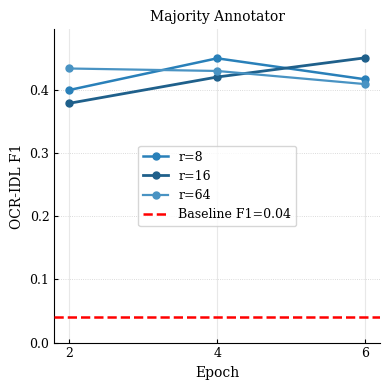

In [12]:
plot_overall_metrics_by_epoch(overall_df_majority, metrics=('f1',), title_template ="Majority Annotator", y_label_template="OCR-IDL F1")

In [ ]:
test_data_file = "/Volumes/MyDataDrive/thesis/code-2/new-data/IIT-CDIP/test/test-data-iit-cdip-840px.json"
pred_labels_dir = "/Volumes/MyDataDrive/thesis/code-2/new-data/benchmarks/trained_model/model_pred/majority_annotator_2/r64_alpha128_train-data-mixed-840px-annotator-2_lr0_000042/checkpoint-94"


results = benchmark_from_file(test_data_file, pred_labels_dir, iou_threshold=0.5)